In [1]:
!pip install kaggle

!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

!unzip imdb-dataset-of-50k-movie-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 86% 22.0M/25.7M [00:01<00:00, 32.6MB/s]
100% 25.7M/25.7M [00:01<00:00, 22.4MB/s]
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [2]:
# Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import re
from bs4 import BeautifulSoup


# Data
import pandas as pd
import numpy as np

# NLP
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

# viz
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
df = pd.read_csv('IMDB Dataset.csv')

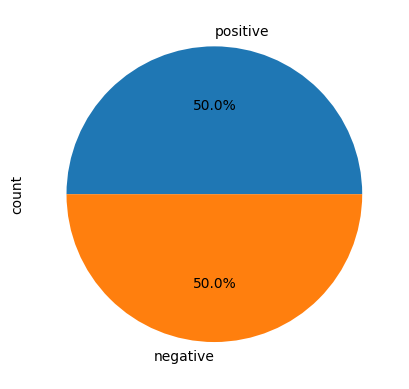

In [4]:
df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

In [5]:
# Fonction pour supprimer les éléments HTML
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

df['review'] = df['review'].apply(remove_html_tags)


<ipython-input-5-532e725e164b>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [6]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

df['review'] = df['review'].apply(remove_punctuation)

In [7]:
def lower_case(text):
    return text.lower()

df['review'] = df['review'].apply(lower_case)

In [8]:
# Stop word
stop_words = set(stopwords.words('english'))

# suppression des stop words.
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

df['review'] = df['review'].apply(remove_stop_words)

In [9]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

df['review'] = df['review'].apply(lemmatize_text)

In [10]:
raw_corpus = "".join(df.review.values)

In [11]:
from collections import Counter

# Combiner toutes les critiques en un seul texte
all_reviews = ' '.join(df['review']).lower()

# Compter la fréquence de chaque mot
words = re.findall(r'\b\w+\b', all_reviews)
word_counts = Counter(words)

# Filtrer les mots qui apparaissent plus de 5 fois
frequent_words = {word for word, count in word_counts.items() if count > 5}

# Fonction pour filtrer les mots dans chaque commentaire
def filter_review(review, frequent_words):
    words = review.lower().split()
    filtered_words = [word for word in words if word in frequent_words]
    return ' '.join(filtered_words)

# Appliquer la fonction à chaque commentaire
df['filtered_review'] = df['review'].apply(filter_review, args=(frequent_words,))

In [12]:
raw_corpus = "".join(df.review.values)
# Diviser le corpus brut en mots individuels
words = raw_corpus.split()

# Utiliser un ensemble pour obtenir les mots uniques
unique_words = set(words)

# Compter le nombre de mots uniques
num_unique_words = len(unique_words)

# Afficher le nombre de mots uniques
print("Nombre de mots uniques dans le corpus brut :", num_unique_words)

Nombre de mots uniques dans le corpus brut : 250551


In [13]:
raw_corpus = "".join(df.filtered_review.values)
# Diviser le corpus brut en mots individuels
words = raw_corpus.split()

# Utiliser un ensemble pour obtenir les mots uniques
unique_words = set(words)

# Compter le nombre de mots uniques
num_unique_words = len(unique_words)

# Afficher le nombre de mots uniques
print("Nombre de mots uniques dans le corpus brut :", num_unique_words)

Nombre de mots uniques dans le corpus brut : 78532


In [14]:
raw_corpus = "".join(df.filtered_review.values)

In [15]:
# tokenize of raw_coprus
tokenizer = RegexpTokenizer(r'\w+')
tokens = tokenizer.tokenize(raw_corpus)

In [16]:
# Utilisez pad_sequences de Keras pour que toutes les séquences aient la même longueur.
# Préparer les commentaires pour la tokenisation
reviews = df['filtered_review'].tolist()

# Initialiser et adapter le Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)

# Convertir les commentaires en séquences de tokens
sequences = tokenizer.texts_to_sequences(reviews)

# Définir la longueur maximale des séquences
max_length = 400

# Appliquer le padding aux séquences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

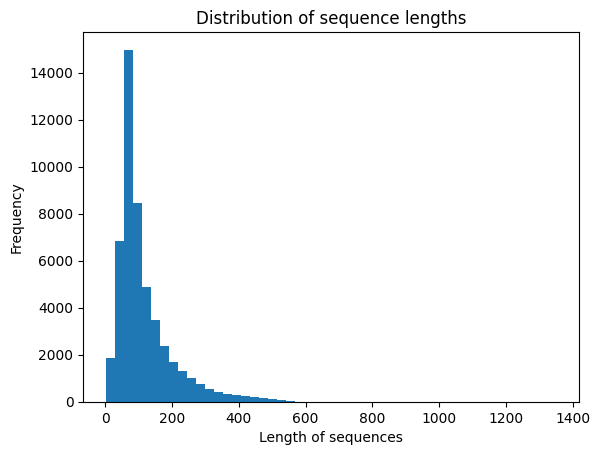

In [17]:
# Histogramme de la longueur des séquences de mots
seq_lengths = [len(seq) for seq in sequences]
plt.hist(seq_lengths, bins=50)
plt.xlabel('Length of sequences')
plt.ylabel('Frequency')
plt.title('Distribution of sequence lengths')
plt.show()

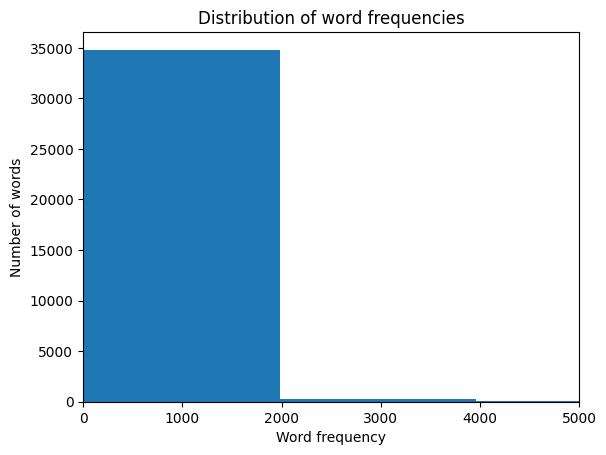

In [18]:
# Histogramme des fréquences des mots différents
word_counts = tokenizer.word_counts.values()
plt.hist(word_counts, bins=50)
plt.xlabel('Word frequency')
plt.ylabel('Number of words')
plt.title('Distribution of word frequencies')
plt.xlim([0, 5000])
plt.show()

In [19]:
# Utilisez LabelEncoder de sklearn pour transformer les labels catégoriels en valeurs numériques.
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['sentiment'])

df['sentiment'] = labels

In [20]:
X = padded_sequences
y = df['sentiment'].values

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [23]:
# Définir le callback ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # La métrique à surveiller
    factor=0.2,            # Facteur par lequel le taux d'apprentissage sera réduit
    patience=5,            # Nombre d'époques avec no amélioration après lesquelles le taux sera réduit
    min_lr=0.001           # Le taux d'apprentissage minimum
)

In [24]:
model_lstm = Sequential([
    Embedding(input_dim=78532, output_dim=128),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')# à vous de voir
])

In [25]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
model_lstm.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
1000/1000 - 94s - loss: 0.6936 - accuracy: 0.5013 - val_loss: 0.6947 - val_accuracy: 0.5026 - lr: 0.0010 - 94s/epoch - 94ms/step
Epoch 2/100
1000/1000 - 48s - loss: 0.6939 - accuracy: 0.5050 - val_loss: 0.6941 - val_accuracy: 0.4974 - lr: 0.0010 - 48s/epoch - 48ms/step
Epoch 3/100
1000/1000 - 36s - loss: 0.6937 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.5035 - lr: 0.0010 - 36s/epoch - 36ms/step
Epoch 4/100
1000/1000 - 35s - loss: 0.6923 - accuracy: 0.5015 - val_loss: 0.6944 - val_accuracy: 0.4978 - lr: 0.0010 - 35s/epoch - 35ms/step
Epoch 5/100
1000/1000 - 32s - loss: 0.6884 - accuracy: 0.5083 - val_loss: 0.6931 - val_accuracy: 0.5035 - lr: 0.0010 - 32s/epoch - 32ms/step
Epoch 6/100
1000/1000 - 35s - loss: 0.6867 - accuracy: 0.5075 - val_loss: 0.6932 - val_accuracy: 0.4986 - lr: 0.0010 - 35s/epoch - 35ms/step
Epoch 7/100
1000/1000 - 31s - loss: 0.6730 - accuracy: 0.5518 - val_loss: 0.6140 - val_accuracy: 0.6952 - lr: 0.0010 - 31s/epoch - 31ms/step
Epoch 8/100
1

In [27]:
# Utilisez confusion_matrix de sklearn pour calculer la matrice de confusion de chaque modèle sur le jeu de test.
model_lstm.evaluate(X_test, Y_test)

313/313 [==============================] - 5s 12ms/step - loss: 0.3391 - accuracy: 0.8740


[0.3391359746456146, 0.8740000128746033]

In [28]:
y_pred = model_lstm.predict(X_test)

313/313 [==============================] - 5s 12ms/step


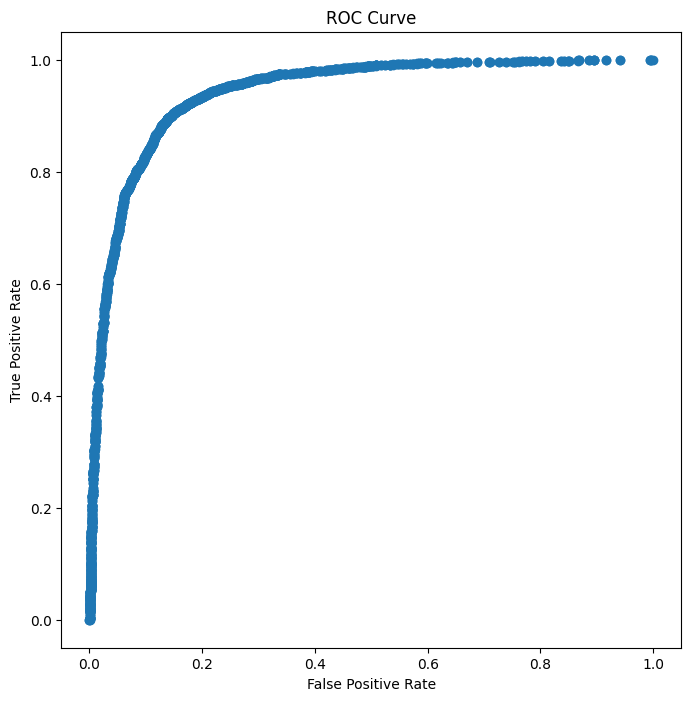

In [48]:
# afficher la roc_curve
plt.figure(figsize=(8, 8))
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
plt.plot(fpr, tpr, "o")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [55]:
print(fpr[1000])
print(tpr[1000])
print(thresholds[1000])

0.07490486681353896
0.7853005791891352
0.9080795


In [38]:
# trouver le meilleur threshold
best_threshold = 0
best_f1 = 0

for threshold in thresholds:
    y_pred_binary = (y_pred > threshold).astype(int)
    f1 = f1_score(Y_test, y_pred_binary)
    if f1 > best_f1:
        best_threshold = threshold
        best_f1 = f1


In [39]:
print(best_threshold)
print(best_f1)

0.40822637
0.880996399727547


In [56]:
# Convert predicted probabilities to binary predictions (0 or 1)
y_pred_binary = (y_pred > best_threshold).astype(int)

accuracy = accuracy_score(Y_test, y_pred_binary)
print(accuracy)

0.8777


In [57]:
precision = precision_score(Y_test, y_pred_binary)
print(precision)

0.8590132827324478


In [58]:
f1 = f1_score(Y_test, y_pred_binary)
print(f1)

0.880996399727547


In [60]:
recall = recall_score(Y_test, y_pred_binary)
print(recall)

0.9041342121030557


# LSTM AVEC ATTENTION


In [66]:
# Ajouter a mon model lstm de l'attention
from tensorflow.keras.layers import Attention, Input, Flatten
from tensorflow.keras.models import Model

In [68]:
input_layer = Input(shape=(400,))
embedding_layer = Embedding(input_dim=78532, output_dim=128)(input_layer)
lstm_layer = LSTM(128, return_sequences=True)(embedding_layer)
attention_layer = Attention()([lstm_layer, lstm_layer])

attention_layer = Flatten()(attention_layer)
output_layer = Dense(1, activation='sigmoid')(attention_layer)

model_lstm_attention = Model(inputs=input_layer, outputs=output_layer)

In [69]:
model_lstm_attention.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [70]:
model_lstm_attention.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
1000/1000 - 83s - loss: 0.3487 - accuracy: 0.8439 - val_loss: 0.2767 - val_accuracy: 0.8941 - lr: 0.0010 - 83s/epoch - 83ms/step
Epoch 2/100
1000/1000 - 39s - loss: 0.1559 - accuracy: 0.9409 - val_loss: 0.3282 - val_accuracy: 0.8811 - lr: 0.0010 - 39s/epoch - 39ms/step
Epoch 3/100
1000/1000 - 29s - loss: 0.0761 - accuracy: 0.9725 - val_loss: 0.4178 - val_accuracy: 0.8751 - lr: 0.0010 - 29s/epoch - 29ms/step
Epoch 4/100
1000/1000 - 26s - loss: 0.0424 - accuracy: 0.9855 - val_loss: 0.6032 - val_accuracy: 0.8742 - lr: 0.0010 - 26s/epoch - 26ms/step
Epoch 5/100
1000/1000 - 25s - loss: 0.0288 - accuracy: 0.9906 - val_loss: 0.7505 - val_accuracy: 0.8721 - lr: 0.0010 - 25s/epoch - 25ms/step
Epoch 6/100
1000/1000 - 24s - loss: 0.0237 - accuracy: 0.9927 - val_loss: 0.9233 - val_accuracy: 0.8673 - lr: 0.0010 - 24s/epoch - 24ms/step


In [71]:
model_lstm_attention.evaluate(X_test, Y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.2717 - accuracy: 0.8947


[0.271684855222702, 0.8946999907493591]

In [72]:
y_pred = model_lstm_attention.predict(X_test)

313/313 [==============================] - 5s 10ms/step


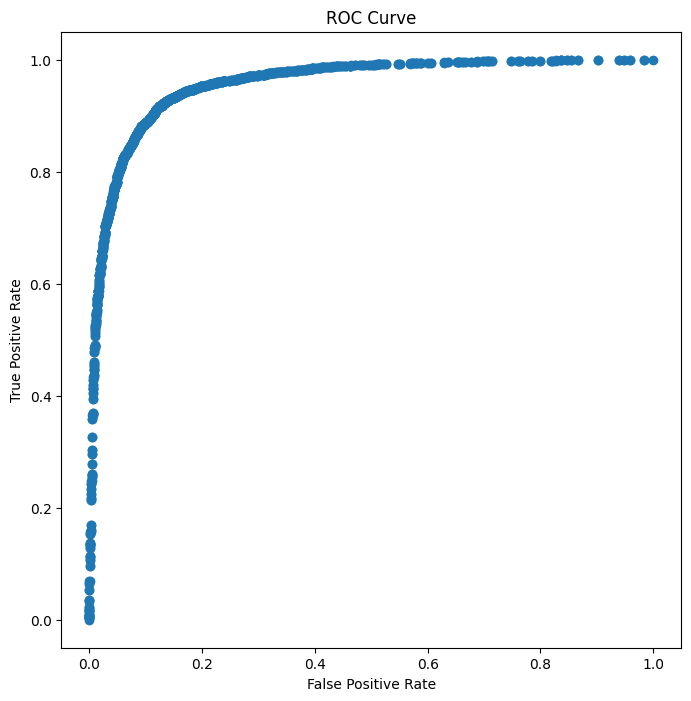

In [73]:
# afficher la roc_curve
plt.figure(figsize=(8, 8))
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
plt.plot(fpr, tpr, "o")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [74]:
# trouver le meilleur threshold
best_threshold = 0
best_f1 = 0

for threshold in thresholds:
    y_pred_binary = (y_pred > threshold).astype(int)
    f1 = f1_score(Y_test, y_pred_binary)
    if f1 > best_f1:
        best_threshold = threshold
        best_f1 = f1

print(best_threshold)
print(best_f1)

0.47384205
0.898590446358653


In [75]:
# Convert predicted probabilities to binary predictions (0 or 1)
y_pred_binary = (y_pred > best_threshold).astype(int)

accuracy = accuracy_score(Y_test, y_pred_binary)
print(accuracy)

0.8964
